In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import time
import math
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
data_list = glob.glob('/content/drive/MyDrive/Colab Notebooks/data/super resolution/train/high_res/*.png')

In [ ]:
data_list_test = glob.glob('/content/drive/MyDrive/Colab Notebooks/data/super resolution/test/high_res/*.png')

In [ ]:
class SRCNNDataset(Dataset):
  def __init__(self, paths):
    self.paths = paths

  def __len__(self):
    return len(self.paths)

  def __getitem__(self, idx):
    path = self.paths[idx]

    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.GaussianBlur(img, (0,0), 1)
    img = cv2.resize(img, dsize=(64,64))
    img = img.astype(np.float32) / 255.0
    img = img[np.newaxis]

    label_img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    label_img = label_img.astype(np.float32) / 255.0
    label_img = label_img[np.newaxis]

    input_sample = torch.tensor(img, dtype=torch.float32)
    label_sample = torch.tensor(label_img, dtype=torch.float32)

    return input_sample, label_sample

In [ ]:
# 데이터셋 생성
train_ds = SRCNNDataset(data_list)
test_ds = SRCNNDataset(data_list_test)

In [ ]:
# 데이터로더 생성
train_dl = DataLoader(train_ds, batch_size=64)
test_dl = DataLoader(test_ds, batch_size=1)

In [ ]:
len(train_dl)

11

In [ ]:
for x, y in train_dl:
  print(x.shape, y.shape)
  break

torch.Size([64, 1, 64, 64]) torch.Size([64, 1, 256, 256])


In [ ]:
img = x[0]
target = y[0]
print(img.shape, target.shape)
print(img.dtype)

torch.Size([1, 64, 64]) torch.Size([1, 256, 256])
torch.float32


Text(0.5, 1.0, 'target')

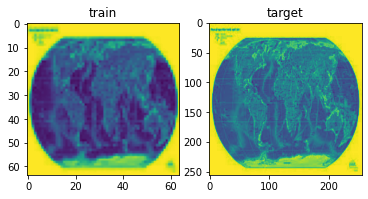

In [ ]:
from torchvision.transforms.functional import to_pil_image

plt.figure()
plt.subplot(1,2,1)
plt.imshow(to_pil_image(img))
plt.title('train')
plt.subplot(1,2,2)
plt.imshow(to_pil_image(target))
plt.title('target')

In [ ]:
class SRCNN(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 64, 9, padding=9//2)
    self.conv2 = nn.Conv2d(64, 32, 1)
    self.conv3 = nn.Conv2d(32, 1, 5, padding=5//2)

  def forward(self, x):
    out = F.interpolate(x, scale_factor=4, mode='bicubic')
    out = F.relu(self.conv1(out))
    out = F.relu(self.conv2(out))
    out = self.conv3(out)

    return out

In [ ]:
# check
x = torch.randn(64,1,64,64).to(device)
model = SRCNN().to(device)
output = model(x)
print(output.shape)

torch.Size([64, 1, 256, 256])


In [ ]:
# 가중치 초기화
def initialize_weights(model):
  classname = model.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(model.weight.data, 0.0, 0.001)
    nn.init.zeros_(model.bias.data)

model.apply(initialize_weights);

In [ ]:
# Super Resolution 정확도 측도인 PSNR(Peak Signal - to - Noise Ratio) 정의
def psnr(label, outputs, max_val=1.):
  label = label.cpu().detach().numpy()
  outputs = outputs.cpu().detach().numpy()

  img_diff = label - outputs
  rmse = math.sqrt(np.mean((img_diff)**2))

  if rmse == 0: # label 데이터와 일치하는 경우
    return 100
  else:
    psnr = 20 * math.log10(max_val/rmse)
    return psnr

In [ ]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
  start = time.time()
  for epoch in range(1, n_epochs + 1):
    loss_train = 0.0
    psnr_train = 0.0

    for _, (image, label) in enumerate(train_loader):
      imgs = image.to(device=device)
      labels = label.to(device=device)

      outputs = model(imgs)
      loss = loss_fn(outputs, labels)
      batch_psnr = psnr(labels, outputs)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      loss_train += loss.item()
      psnr_train += batch_psnr

    if epoch == 1 or epoch % 10 == 0:
      print('Epoch {}, Training loss {}, Training psnr {}'.format(epoch, loss_train / len(train_loader), psnr_train / int(len(train_ds)/train_loader.batch_size)))

  final_loss = loss_train / len(train_loader)
  final_psnr = psnr_train / int(len(train_ds)/train_loader.batch_size)
  end = time.time()
  print('Total Training time is {} sec'.format(end-start))
  return final_loss, final_psnr

In [ ]:
def validate(model, loss_fn, validation_loader):
  model.eval()
  loss_val = 0.0
  psnr_val = 0.0

  with torch.no_grad():
    for _, data in enumerate(validation_loader):
      imgs = data[0].to(device=device)
      labels = data[1].to(device=device)
      outputs = model(imgs)
      loss = loss_fn(outputs, labels)
      batch_psnr = psnr(labels, outputs)

      loss_val += loss.item()
      psnr_val += batch_psnr

    outputs = outputs.cpu()

  final_loss = loss_val / len(validation_loader)
  final_psnr = psnr_val / int(len(test_ds)/validation_loader.batch_size)
  return final_loss, final_psnr

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [ ]:
training_loop(
    n_epochs = 500,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_dl
)

Epoch 1, Training loss 0.21501848982139068, Training psnr 7.529957426627189
Epoch 10, Training loss 0.008389380760490894, Training psnr 22.845117733595366
Epoch 20, Training loss 0.004344668472185731, Training psnr 25.990228034916253
Epoch 30, Training loss 0.004194655878977342, Training psnr 26.158462654322665
Epoch 40, Training loss 0.0040601748041808605, Training psnr 26.314525517096275
Epoch 50, Training loss 0.003927743104709821, Training psnr 26.47335373955871
Epoch 60, Training loss 0.003800462084737691, Training psnr 26.631164547233517
Epoch 70, Training loss 0.0036953420759263363, Training psnr 26.765503542161166
Epoch 80, Training loss 0.003604603825475682, Training psnr 26.884281463833865
Epoch 90, Training loss 0.0035646756348962135, Training psnr 26.937592486013404
Epoch 100, Training loss 0.0034958110190927982, Training psnr 27.03132742339792
Epoch 110, Training loss 0.0034628377973356032, Training psnr 27.0769189673227
Epoch 120, Training loss 0.0035836249589920044, Trai

(0.003101664193143899, 27.60564282620779)

In [ ]:
validate(
    model = model,
    loss_fn = loss_fn,
    validation_loader = test_dl
)

(0.0031349071211640395, 26.084360366456572)

Text(0.5, 1.0, 'ground_truth')

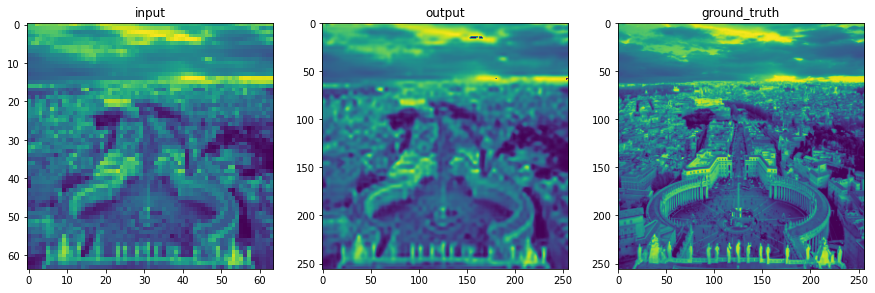

In [ ]:
from torchvision.transforms.functional import to_pil_image
# 이미지 꺼내기
for img, label in test_dl:
    img = img[0]
    label = label[0]
    break

# super-resolution
model.eval()
with torch.no_grad():
    img_ = img.unsqueeze(0)
    img_ = img_.to(device)
    output = model(img_)
    output = output.squeeze(0)

#print(img)
#print(output)
# 시각화
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(to_pil_image(img))
plt.title('input')
plt.subplot(1,3,2)
plt.imshow(to_pil_image(output))
plt.title('output')
plt.subplot(1,3,3)
plt.imshow(to_pil_image(label))
plt.title('ground_truth')